In [1]:
# testing_partialVAE_spliceVI.ipynb

# import sys
# sys.path.insert(0, "/gpfs/commons/home/kisaev/scvi-tools-splicing/src")
# from scvi.model._splicevi import SPLICEVI

# Define CODE_DIM = 32 early on so can use it for getting initial junction embeddings for the model
CODE_DIM = 32  
 
import anndata as ad
import numpy as np 
import pandas as pd
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns
import torch
import numpy as np
import scipy.sparse as sparse

# Load AnnData object with simulated single cell splicing data 
adata = ad.read_h5ad("/gpfs/commons/groups/knowles_lab/Karin/TMS_MODELING/DATA_FILES/SIMULATED/simulated_data_2025-03-12.h5ad")

# Basic info about the data
print("\nAnnData Summary:")
print(adata)
print("\nLayers:")
for layer_name, layer in adata.layers.items():
    print(f"  {layer_name}: {type(layer)}, shape {layer.shape}")

# Only keep the layers we actually need for training 
trimmed_layers = {
    key: adata.layers[key]
    for key in ["junc_ratio", "cell_by_cluster_matrix", "cell_by_junction_matrix"]
}

# Create trimmed AnnData
adata_trimmed = ad.AnnData(
    X=None,  # Don't include full X matrix
    obs=adata.obs.copy(),
    var=adata.var.copy(),
    layers=trimmed_layers
)


AnnData Summary:
AnnData object with n_obs × n_vars = 19942 × 9798
    obs: 'cell_id', 'age', 'batch', 'cell_ontology_class', 'method', 'mouse.id', 'sex', 'tissue', 'old_cell_id_index', 'cell_clean', 'cell_id_index', 'subtissue_clean', 'cell_type_grouped', 'cell_type'
    var: 'junction_id', 'event_id', 'splice_motif', 'label_5_prime', 'label_3_prime', 'annotation_status', 'gene_name', 'gene_id', 'num_junctions', 'position_off_5_prime', 'position_off_3_prime', 'CountJuncs', 'non_zero_count_cells', 'non_zero_cell_prop', 'annotation_status_score', 'non_zero_cell_prop_score', 'splice_motif_score', 'junction_id_index', 'chr', 'start', 'end', 'index', '0', '1', '2', '3', '4', '5', '6', '7', '8', 'sample_label', 'difference', 'true_label'
    uns: 'age_colors', 'cell_type_colors', 'neighbors', 'pca_explained_variance_ratio', 'tissue_colors', 'umap'
    obsm: 'X_leafletFA', 'X_pca', 'X_umap', 'phi_init_100_waypoints', 'phi_init_30_waypoints'
    varm: 'psi_init_100_waypoints', 'psi_init_30_w

/gpfs/commons/home/svaidyanathan/miniconda3/envs/scvi-env/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [2]:
import numpy as np
import scipy.sparse as sp
from anndata import AnnData

# --- 1) grab the two layers ---
junc = adata.layers["cell_by_junction_matrix"]
clus = adata.layers["cell_by_cluster_matrix"]

# --- 2) convert both to dense float arrays (so division broadcasts element‐wise) ---
if sp.issparse(junc):
    junc = junc.toarray().astype(float)
else:
    junc = junc.astype(float)
if sp.issparse(clus):
    clus = clus.toarray().astype(float)
else:
    clus = clus.astype(float)

# --- 3) do the element‐wise division, silencing warnings so zeros → NaN ---
with np.errstate(divide="ignore", invalid="ignore"):
    ratio = junc / clus  # shape (n_cells, n_junctions), NaN where clus == 0

# (optionally) convert back to sparse if you prefer
ratio_layer = sp.csr_matrix(ratio)

# --- 4) build your trimmed AnnData, swapping in the new ratio_layer ---
trimmed_layers = {
    "junc_ratio": ratio_layer,
    "cell_by_cluster_matrix": adata.layers["cell_by_cluster_matrix"],
    "cell_by_junction_matrix": adata.layers["cell_by_junction_matrix"],
}

adata_trimmed = AnnData(
    X=None,
    obs=adata.obs.copy(),
    var=adata.var.copy(),
    layers=trimmed_layers,
)


Shape: (157418, 16530), dtype: float64
Number of NaNs in junc_ratio: 2030347842


/scratch/ipykernel_433305/2962349054.py:48: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


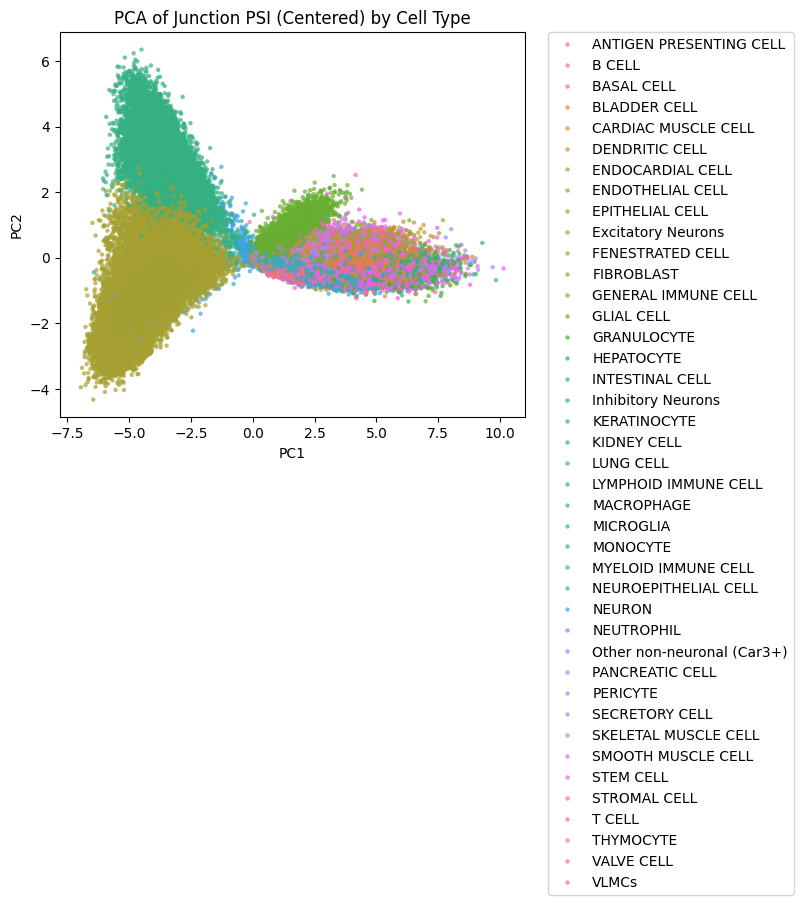

Silhouette Score (cell type, top 10 PCs): -0.1446


In [ ]:
# Get initial embedding 

# Check if any NaNs in junc_ratio and if it’s still sparse, convert to a dense NumPy array
X = adata_trimmed.layers["junc_ratio"] 
if sp.issparse(X):
    X = X.toarray()
X = np.asarray(X)

print(f"Shape: {X.shape}, dtype: {X.dtype}")
print(f"Number of NaNs in junc_ratio: {np.isnan(X).sum()}")

# Simple centering of non zero PSI values for each splice junction 
# 1: Compute mean of non-NaN values per column (axis=0)
col_means = np.nanmean(X, axis=0)
# 2: Subtract column means from non-NaN entries
X_centered = X - col_means[np.newaxis, :]  # broadcast subtraction
# 3: Replace NaNs (which are now just untouched entries) with 0
X_centered[np.isnan(X_centered)] = 0.0

# Run PCA! 
pca = PCA(n_components=CODE_DIM)
X_pca = pca.fit_transform(X_centered)  # shape: (n_cells, CODE_DIM)
pca_components = pca.components_.T  # shape: (n_junctions, CODE_DIM)

#  Make DataFrame for plotting
df_plot = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "broad_cell_type": adata_trimmed.obs["broad_cell_type"].values
})

# Count the top 10 most common cell types
top10_celltypes = df_plot["broad_cell_type"].value_counts().nlargest(10).index
df_top10 = df_plot[df_plot["broad_cell_type"].isin(top10_celltypes)].copy()

plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=df_top10,
    x="PC1", y="PC2",
    hue="broad_cell_type",
    s=10, alpha=0.7,
    linewidth=0
)
plt.title("PCA of Junction PSI (Centered) — Top 10 Cell Types")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder

# Encode labels as integers
cell_type_labels = adata_trimmed.obs["dataset"].values
label_encoder = LabelEncoder()
cell_type_encoded = label_encoder.fit_transform(cell_type_labels)

# Compute silhouette score on PCA space
sil_score = silhouette_score(X_pca[:, :10], cell_type_encoded, metric='euclidean')  # use top 10 PCs
print(f"Silhouette Score (cell type, top 10 PCs): {sil_score:.4f}")

In [3]:
# Layer names
x_layer = "junc_ratio"
junction_counts_layer = "cell_by_junction_matrix"
cluster_counts_layer = "cell_by_cluster_matrix"
mask_layer = "mask"

# --- Construct mask from cluster counts ---
if cluster_counts_layer in adata_trimmed.layers:
    cc = adata_trimmed.layers[cluster_counts_layer]
    cc_array = cc.toarray() if sparse.issparse(cc) else np.asarray(cc)
    mask = (cc_array > 0).astype(np.uint8)
    adata_trimmed.layers[mask_layer] = sparse.csr_matrix(mask)
    print(f"Mask layer `{mask_layer}` created from `{cluster_counts_layer}`.")

# --- Preprocess junction ratio layer ---
if x_layer in adata_trimmed.layers:
    jr = adata_trimmed.layers[x_layer]
    jr_array = jr.toarray() if sparse.issparse(jr) else np.asarray(jr)
    adata_trimmed.layers[x_layer] = sparse.csr_matrix(np.nan_to_num(jr_array, nan=0.0))
    print(f"Cleaned NaNs in `{x_layer}` and converted to CSR.")

# --- Ready for SPLICEVI setup ---
from scvi.model import SPLICEVI

SPLICEVI.setup_anndata(
    adata_trimmed,
    junc_ratio_layer=x_layer,
    junc_counts_layer=junction_counts_layer,
    cluster_counts_layer=cluster_counts_layer,
    psi_mask_layer=mask_layer,
    batch_key="mouse.id"  
)

Mask layer `mask` created from `cell_by_cluster_matrix`.
Cleaned NaNs in `junc_ratio` and converted to CSR.


In [4]:
# ------------------------------
# 1. Grab train() defaults
# ------------------------------
import inspect
import scvi

train_sig = inspect.signature(scvi.model.SPLICEVI.train)
train_defaults = {
    name: param.default
    for name, param in train_sig.parameters.items()
    if name != 'self' and param.default is not inspect._empty
}

# ------------------------------
# 2. Grab __init__ defaults for model
# ------------------------------
init_sig = inspect.signature(scvi.model.SPLICEVI.__init__)
init_defaults = {
    name: param.default
    for name, param in init_sig.parameters.items()
    if name not in ('self', 'adata') and param.default is not inspect._empty
}

In [5]:
# Initialize model
model = SPLICEVI(
    adata=adata_trimmed,
    code_dim=CODE_DIM,
    h_hidden_dim=64,
    encoder_hidden_dim=128,
    latent_dim=30,
    dropout_rate=0.01,
    learn_concentration=True,
    splice_likelihood="beta-binomial"
)

model.view_anndata_setup()

Anndata setup with scvi-tools version 1.3.1.

Setup via `SPLICEVI.setup_anndata` with arguments:

{
│   'junc_ratio_layer': 'junc_ratio',
│   'junc_counts_layer': 'cell_by_junction_matrix',
│   'cluster_counts_layer': 'cell_by_cluster_matrix',
│   'psi_mask_layer': 'mask',
│   'batch_key': 'mouse.id',
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

      Summary Statistics       
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃  Summary Stat Key   ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│       n_batch       │  15   │
│       n_cells       │ 19942 │
│  n_cluster_counts   │ 9798  │
│  n_junction_counts  │ 9798  │
│ n_psi_observed_mask │ 9798  │
│       n_vars        │ 9798  │
└─────────────────────┴───────┘

                         Data Registry                         
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Registry Key    ┃           scvi-tools Location           ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         X         │       adata.layers['junc_ratio']        │
│       batch       │        adata.obs['_scvi_batch']         │
│  cluster_counts   │ adata.layers['cell_by_cluster_matrix']  │
│  junction_counts  │ adata.layers['cell_by_junction_matrix'] │
│ psi_observed_mask │          adata.layers['mask']           │
└───────────────────┴─────────────────────────────────────────┘

                    batch State Registry                    
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['mouse.id'] │   3_8_M    │          0          │
│                       │   3_9_M    │          1          │
│                       │   3_10_M   │          2          │
│                       │   3_11_M   │          3          │
│                       │   3_38_F   │          4          │
│                       │   3_39_F   │          5          │
│                       │   3_56_F   │          6          │
│                       │  18_45_M   │          7          │
│                       │  18_46_F   │          8          │
│                       │  18_47_F   │          9          │
│                       │  18_53_M   │         10          │
│                       │  24_58_M   │         11          │
│                       │  24_59_M   │         12          │
│                       │  24_60_M   │         13          │
│                       │  24_61_M   │         14          │
└───────────────────────┴────────────┴─────────────────────┘

In [13]:
# Add PCA embedding for initialization
# Get feature embedding before PCA init
pca_tensor = torch.tensor(pca_components, dtype=model.module.encoder.feature_embedding.dtype)
embedding_tensor = model.module.encoder.feature_embedding.detach()

diff = torch.norm(embedding_tensor - pca_tensor).item()
print(f"L2 norm between PCA loadings and random model embedding: {diff:.6f}")

model.module.initialize_feature_embedding_from_pca(pca_components)
pca_tensor = torch.tensor(pca_components, dtype=model.module.encoder.feature_embedding.dtype)
embedding_tensor = model.module.encoder.feature_embedding.detach()
diff = torch.norm(embedding_tensor - pca_tensor).item()
print(f"L2 norm between initialized PCA and model embedding: {diff:.6f}")


L2 norm between PCA loadings and random model embedding: 727.294617
L2 norm between initialized PCA and model embedding: 0.000000


In [ ]:
# Train the model
model.train(
    max_epochs=5,
    lr=1e-3,
    batch_size=512,
    early_stopping=True,
    n_epochs_kl_warmup=0,
    weight_decay=0.05,
    save_best=False,
    check_val_every_n_epoch=1
)


Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/gpfs/commons/home/kisaev/miniconda3/envs/scvi-env/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /gpfs/commons/home/kisaev/miniconda3/envs/scvi-env/l ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/gpfs/commons/home/kisaev/miniconda3/envs/scvi-env/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightn

Epoch 5/5: 100%|██████████| 5/5 [12:23<00:00, 148.92s/it, v_num=1, train_loss_step=3.81, train_loss_epoch=4.58]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 5/5: 100%|██████████| 5/5 [12:23<00:00, 148.76s/it, v_num=1, train_loss_step=3.81, train_loss_epoch=4.58]


In [ ]:
import scanpy as sc
print("Computing latent representation and UMAP…")
adata_trimmed.obsm['X_splicevi'] = model.get_latent_representation()
sc.pp.neighbors(adata_trimmed, use_rep='X_splicevi')
sc.tl.umap(adata_trimmed, min_dist=0.1)
print("UMAP embedding done.")

In [ ]:
sc.pl.umap(adata_trimmed, color="dataset")

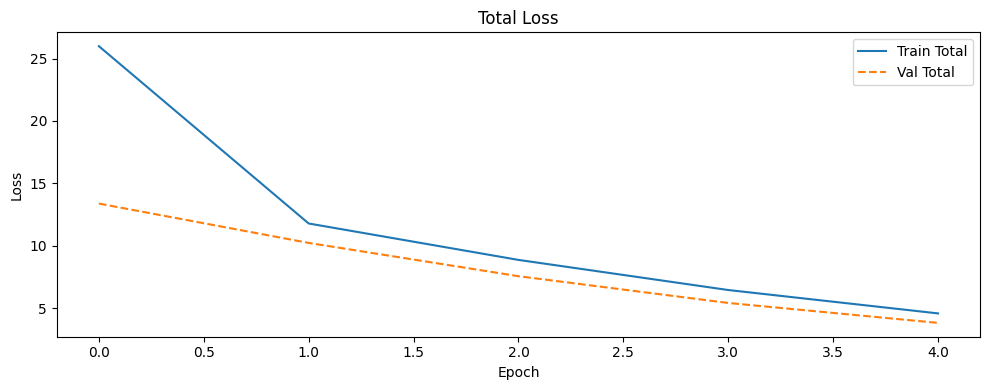

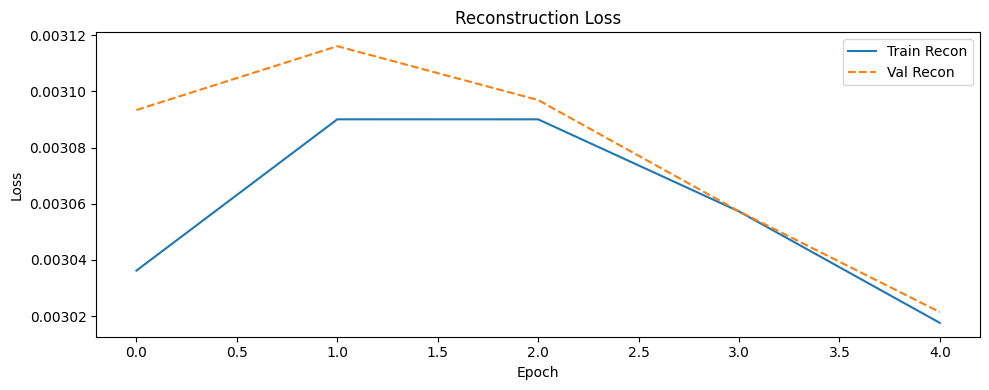

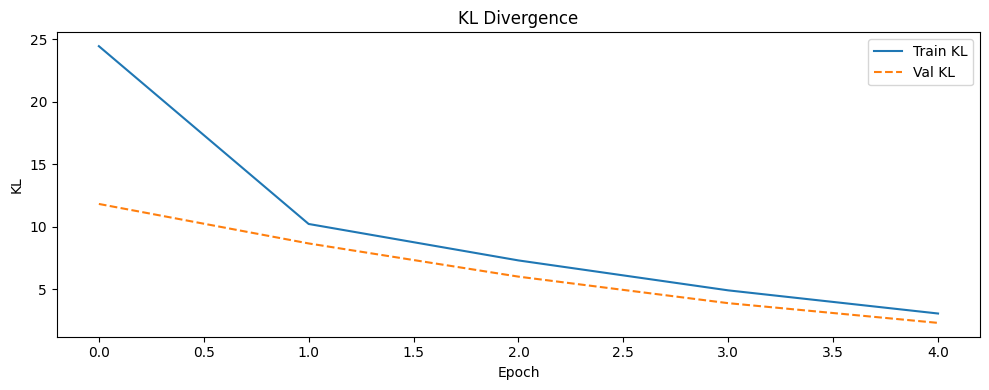

In [16]:
import pandas as pd

# Convert history dictionary (of DataFrames) into a single DataFrame
df = pd.concat(model.history.values(), axis=1)
df.reset_index(inplace=True)

import matplotlib.pyplot as plt

# Total loss
plt.figure(figsize=(10, 4))
plt.plot(df["epoch"], df["train_loss_epoch"], label="Train Total")
plt.plot(df["epoch"], df["validation_loss"], label="Val Total", linestyle="--")
plt.title("Total Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# Reconstruction loss
plt.figure(figsize=(10, 4))
plt.plot(df["epoch"], df["reconstruction_loss_train"], label="Train Recon")
plt.plot(df["epoch"], df["reconstruction_loss_validation"], label="Val Recon", linestyle="--")
plt.title("Reconstruction Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# KL Divergence
plt.figure(figsize=(10, 4))
plt.plot(df["epoch"], df["kl_local_train"], label="Train KL")
plt.plot(df["epoch"], df["kl_local_validation"], label="Val KL", linestyle="--")
plt.title("KL Divergence")
plt.xlabel("Epoch")
plt.ylabel("KL")
plt.legend()
plt.tight_layout()
plt.show()
